# Malware Detection using PEFile and Vector Search

3/24/2025, Dave Sisk, https://github.com/davidcsisk, https://www.linkedin.com/in/davesisk-doctordatabase/

This notebook is an exercise in malware detection done leveraging AI tech.  I've taken common files from (in this case) a Windows 11 laptop, used the pefile package to extract relevant data from the binary executable, then generated vector embeddings from that extracted data.  We proceed to do some similarity searches/comparisons, cluster the files based on their vector embeddings, then reduce the dimensionality and scatterplot them for a visual interpretation.

In [ ]:
# Install any necessary packages
#! pip install pefile
#! pip install pandas

In [1]:
# Import the relevant libraries
import os
import pefile
import pandas as pd
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity

c:\Users\Dave Sisk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sentence_transformers\cross_encoder\CrossEncoder.py:11: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm, trange


In [2]:
# Check our current working directory
print("Current working directory:", os.getcwd())

Current working directory: c:\Users\Dave Sisk\Repos\vector-search-with-security-logs\vector-search-with-security-logs


In [5]:
# Function to read a text file into a list, ignoring lines that start with #
def read_file_to_list(file_path):
    try:
        with open(file_path, 'r') as file:
            # Read lines, strip whitespace, and ignore lines starting with '#'
            lines = [line.strip() for line in file if line.strip() and not line.strip().startswith('#')]
        return lines
    except Exception as e:
        print(f"Error reading file: {e}")
        return []

The file with the list of exe's to examine should look like this...a "#" can be used to comment-out lines: 
```
C:\Windows\System32\calc.exe
C:\Windows\System32\certutil.exe
#C:\Windows\System32\charmap.exe
C:\Windows\System32\CheckNetIsolation.exe
C:\Windows\System32\chglogon.exe
...
```
You can generate a list of files to examine with a command like this:
```
dir /B *.exe > exe-file-list.txt
```

In [6]:
# Get the full list from a pre-created text file
file_path = ".\\exe-file-list.txt"  # Replace with the path to your text file
executables = read_file_to_list(file_path)

print(f"Found {len(executables)} executables in the list.")

Found 655 executables in the list.


In [7]:
# Function to extract PE file features
def extract_pe_features(file_path):
    try:
        pe = pefile.PE(file_path)
        features = {
            "File": os.path.basename(file_path),
            "NumberOfSections": len(pe.sections),
            "EntryPoint": pe.OPTIONAL_HEADER.AddressOfEntryPoint,
            "ImageBase": pe.OPTIONAL_HEADER.ImageBase,
            "Subsystem": pe.OPTIONAL_HEADER.Subsystem,
            "DllCharacteristics": pe.OPTIONAL_HEADER.DllCharacteristics,
            # Ensure ImportedDLLs is always present, even if empty
            "ImportedDLLs": [entry.dll.decode('utf-8') for entry in pe.DIRECTORY_ENTRY_IMPORT] if hasattr(pe, 'DIRECTORY_ENTRY_IMPORT') else []
        }
        return features
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None

In [8]:
# Extract features for all executables
data = []
for exe in executables:
    features = extract_pe_features(exe)
    if features:
        data.append(features)

# Create a pandas DataFrame
df = pd.DataFrame(data)

# Ensure ImportedDLLs column exists and handle missing values
if 'ImportedDLLs' not in df.columns:
    df['ImportedDLLs'] = ''
else:
    df['ImportedDLLs'] = df['ImportedDLLs'].apply(lambda x: ' '.join(x) if isinstance(x, list) else '')

df.shape

(655, 7)

In [9]:
# Take a look at the extracted data
df.sample(3)

,File,NumberOfSections,EntryPoint,ImageBase,Subsystem,DllCharacteristics,ImportedDLLs
348,nvspinfo.exe,6,143776,5368709120,3,49504,api-ms-win-crt-runtime-l1-1-0.dll api-ms-win-c...
177,efsui.exe,6,7280,5368709120,2,49504,ADVAPI32.dll KERNEL32.dll msvcrt.dll EFSADU.dl...
70,chgusr.exe,6,13808,5368709120,3,49504,KERNEL32.dll USER32.dll ntdll.dll ADVAPI32.dll...


Let's concatenate all of the relevant columns into one composite column that we will have the LLM calculate the vector embeddings for.

In [10]:
# Concatenate specified fields into a comma-delimited value and add as a new column "document"
def create_document(row):
    # Convert each field to a string and handle lists (e.g., ImportedDLLs)
    number_of_sections = str(row['NumberOfSections'])
    entry_point = str(row['EntryPoint'])
    image_base = str(row['ImageBase'])
    subsystem = str(row['Subsystem'])
    dll_characteristics = str(row['DllCharacteristics'])
    imported_dlls = ', '.join(row['ImportedDLLs']) if isinstance(row['ImportedDLLs'], list) else str(row['ImportedDLLs'])
    
    # Concatenate all fields into a single comma-delimited string
    document = f"{number_of_sections}, {entry_point}, {image_base}, {subsystem}, {dll_characteristics}, {imported_dlls}"
    return document

# Apply the function to each row in the DataFrame
df['composite'] = df.apply(create_document, axis=1)


In [11]:
df['composite'].sample(3)

313    7, 301040, 5368709120, 2, 49504, ADVAPI32.dll ...
398    6, 577104, 5368709120, 2, 49504, api-ms-win-co...
292    7, 18624, 5368709120, 2, 49504, api-ms-win-crt...
Name: composite, dtype: object

In [ ]:
# Load the Hugging Face sentence-transformer model
model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')

# Generate embeddings using the model
# Let's see what we get if we use only the imported DLL's
df['Embedding'] = df['composite'].apply(lambda x: model.encode(x))


c:\Users\Dave Sisk\AppData\Local\Programs\Python\Python311\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


We now have vector embeddings that capture a signature of the files we examined.  We can do similarity searches, clustering, anomaly detection, etc., using those vector embeddings.

In [13]:
## Example: Perform a similarity search

# Specify the file name to use as the query
#query_file = "calc.exe"  # Replace with the desired file name
query_file = "cmd.exe"  # Replace with the desired file name

# Ensure the file exists in the DataFrame
if query_file in df['File'].values:
    query_vector = df.loc[df['File'] == query_file, 'Embedding'].values[0]  # Get the embedding for the specified file
else:
    raise ValueError(f"File '{query_file}' not found in the DataFrame.")


similarities = df['Embedding'].apply(lambda x: cosine_similarity([query_vector], [x]).flatten()[0])

# Add similarity scores to the DataFrame
df['Similarity'] = similarities

# Sort the DataFrame by the 'Similarity' column in descending order
df = df.sort_values(by='Similarity', ascending=False)

# Display the relevant columns in the sorted DataFrame
print(df[['File', 'Similarity']])


                                 File  Similarity
84                            cmd.exe    1.000000
127                   DeviceEject.exe    0.978991
284            MdmDiagnosticsTool.exe    0.976710
74                         CIDiag.exe    0.974532
5     AppHostRegistrationVerifier.exe    0.974422
..                                ...         ...
560  UevTemplateBaselineGenerator.exe    0.306560
616                       winload.exe    0.264095
618                     winresume.exe    0.238614
554                        tzsync.exe    0.197826
533                     tcblaunch.exe    0.197333

[655 rows x 2 columns]


In [22]:
# Let's cluster the files using DBSCAN on the vector embeddings
from sklearn.cluster import DBSCAN
import numpy as np

# Extract embeddings from the DataFrame
embeddings = np.vstack(df['Embedding'].values)  # Convert list of embeddings to a 2D NumPy array

# Perform DBSCAN clustering
dbscan = DBSCAN(eps=0.1, min_samples=3, metric='cosine')  # Adjust eps and min_samples as needed
labels = dbscan.fit_predict(embeddings)

# Add cluster labels to the DataFrame
df['Cluster'] = labels

# Display the total count by cluster group
cluster_counts = df['Cluster'].value_counts()
print("Total count by cluster group:")
print(cluster_counts)


Total count by cluster group:
Cluster
 0    611
-1     31
 1      8
 2      5
Name: count, dtype: int64


In [23]:
# If you want to see which files are in which cluster group
df[['File', 'Cluster']]


,File,Cluster
84,cmd.exe,0
127,DeviceEject.exe,0
284,MdmDiagnosticsTool.exe,0
74,CIDiag.exe,0
5,AppHostRegistrationVerifier.exe,0
...,...,...
560,UevTemplateBaselineGenerator.exe,-1
616,winload.exe,-1
618,winresume.exe,-1
554,tzsync.exe,-1


In [24]:
# Files by cluster group (the small clusters are of interest)
df[['File', 'Cluster']][(df['Cluster'] == 1)]

,File,Cluster
27,autofmt.exe,1
229,iaStorAfsNative.exe,1
475,setupcl.exe,1
26,autoconv.exe,1
377,poqexec.exe,1
502,srdelayed.exe,1
25,autochk.exe,1
490,smss.exe,1


In [25]:
# Files by cluster group (the small clusters are of interest)
df[['File', 'Cluster']][(df['Cluster'] == 2)]

,File,Cluster
504,stordiag.exe,2
280,MCU.exe,2
558,UevAgentPolicyGenerator.exe,2
561,UevTemplateConfigItemGenerator.exe,2
289,Microsoft.Uev.SyncController.exe,2


In [26]:
# Files by cluster group (the small clusters are of interest)
df[['File', 'Cluster']][(df['Cluster'] == 3)]

,File,Cluster


In [28]:
# Files by cluster group (the small clusters are of interest)
# In particular, DBSCAN flags outliers that don't fit well into an 
# existing cluster as -1...let's take a look at those.
df[['File', 'Cluster']][(df['Cluster'] == -1)]

,File,Cluster
585,VsGraphicsDesktopEngine.exe,-1
35,bcmCVRemoteServer.exe,-1
344,ntoskrnl.exe,-1
541,TpmTool.exe,-1
508,SyncAppvPublishingServer.exe,-1
230,iaStorAfsService.exe,-1
637,wscadminui.exe,-1
629,WorkFolders.exe,-1
276,MbaeParserTask.exe,-1
240,InfDefaultInstall.exe,-1


Let's use PCA to do dimension reduction from the 512 dimensions of the vector embeddings to 2 dimensions so we can plot the cluster groups.

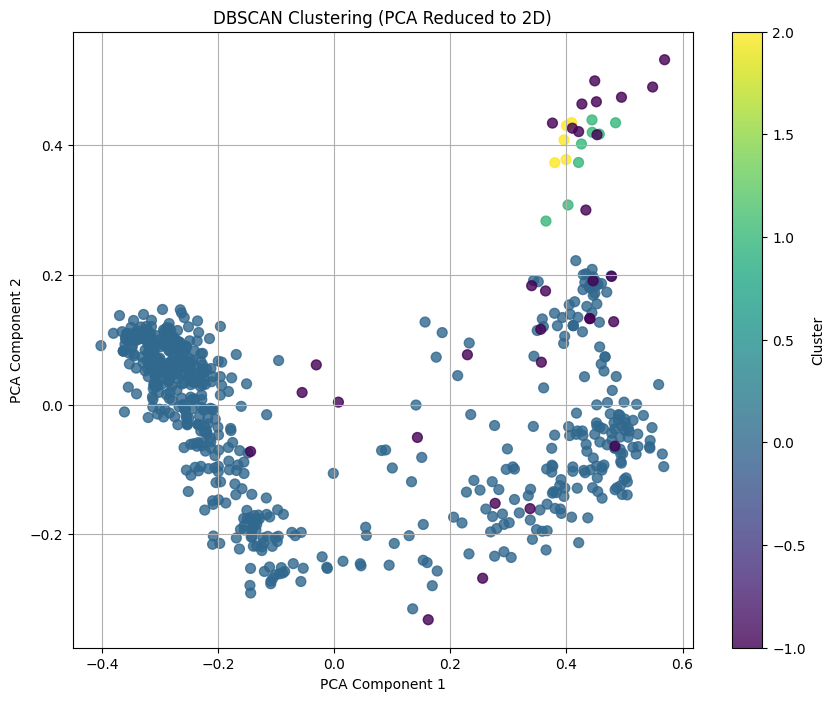

In [29]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Reduce embeddings to 2D using PCA
pca = PCA(n_components=2)
reduced_embeddings = pca.fit_transform(embeddings)

# Add the reduced dimensions to the DataFrame for visualization
df['PCA1'] = reduced_embeddings[:, 0]
df['PCA2'] = reduced_embeddings[:, 1]

# Scatterplot of the clusters
plt.figure(figsize=(10, 8))
scatter = plt.scatter(
    df['PCA1'], 
    df['PCA2'], 
    c=df['Cluster'],  # Color by cluster
    cmap='viridis',   # Use a colormap for clusters
    s=50,             # Marker size
    alpha=0.8         # Transparency
)
plt.colorbar(scatter, label='Cluster')  # Add a colorbar to indicate clusters
plt.title('DBSCAN Clustering (PCA Reduced to 2D)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.grid(True)
plt.show()

So, how well does this work?  It's difficult to tell for certain without some known malware executables to examine, but that's quite a significant next step.  Based on the file list and my knowledge of what each executable's functional purpose is, this process does appear to work at least reasonably well.  

Note that malware detection is a very deep subject, and this notebook is only scratching the surface.  Ways to improve this process include obtaining some malware samples to test with, determining how to get more detailed relevant info out of the pefile utility, examining other utilities similar to pefile that are not platform-independent, etc.  That said, I hope this notebook takes you from having no idea how to go about this to at least some insight into one very generic way to accomplish the detection task. 

While there are sources of live malware samples (like The Zoo on github.com), do realize that you must adequately contain the analysis to an extremely isolated environment (like a locked-down virtual machine with no network, for instance)...live malware will try to propagate, infecting your analysis workstation and other computing devices on your network. If you attempt analysis with live malware, you must do it in the most isolated environment possible.  If you don't know how to do that, please go learn those skills first...you'll be glad you did! 